##**Created By:  [Md. Zobayer Ibna Kabir](https://github.com/ZobayerAkib)**

#**Drive Mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Import Libraries**

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
from sklearn.metrics import classification_report
from keras.applications import *
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from sklearn.utils import class_weight
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet_v2 import preprocess_input as base_preprocess
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from keras.applications import InceptionResNetV2
from keras.applications import DenseNet201
from keras.layers import Dense, GlobalAveragePooling2D
import itertools

#**Image data load**

In [ ]:
data = np.load('/content/drive/MyDrive/Medical Image/PaperOne/image_data.npy',mmap_mode='r')
labels = np.load('/content/drive/MyDrive/Medical Image/PaperOne/labels.npy',mmap_mode='r')

In [ ]:
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (780, 224, 224, 3)
Labels shape: (780, 3)


#**Loading Images from the data**

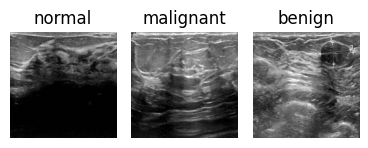

In [ ]:
unique_classes = np.unique(labels, axis=1)

# Create a dictionary to store one data sample from each class
class_samples = {}

# Map class indices to their corresponding names
class_names = {0: "benign", 1: "malignant", 2: "normal"}

# Select one data sample from each class
for class_label in unique_classes:
    class_indices = np.where(np.all(labels == class_label, axis=1))[0]
    class_samples[tuple(class_label)] = data[class_indices[0]]

# Plot the images in 2 rows
plt.figure(figsize=(5, 4))
for i, (class_label, image_data) in enumerate(class_samples.items()):
    class_index = np.argmax(class_label)  # Get the index of the class
    class_name = class_names[class_index]  # Get the corresponding class name
    plt.subplot(2, 4, i + 2)
    plt.imshow(image_data)
    plt.title(f'{class_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()

#**Frequency of the data**

In [ ]:
class_counts = np.sum(labels, axis=0)
print(class_counts)

[437. 210. 133.]


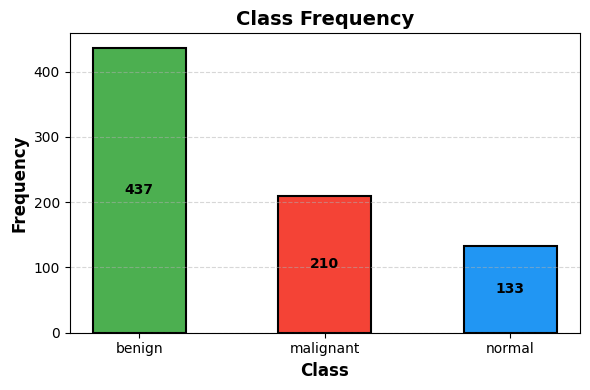

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sum the one-hot encoded labels along the rows to get the frequency of each class
class_counts = np.sum(labels, axis=0)

# Map class indices to their corresponding names
class_names = {0: "benign", 1: "malignant", 2: "normal"}

# Create a more compact and stylish plot
plt.figure(figsize=(6, 4))  # Smaller figure size

# Custom sleek colors
colors = ['#4CAF50', '#F44336', '#2196F3']

# Plot the bar chart with thinner bars and sleek design
bars = plt.bar([class_names[class_idx] for class_idx in range(len(class_names))], class_counts,
               color=colors, width=0.5, edgecolor='black', linewidth=1.5)

# Add labels and title with more compact font size
plt.xlabel('Class', fontsize=12, fontweight='bold', family='sans-serif')
plt.ylabel('Frequency', fontsize=12, fontweight='bold', family='sans-serif')
plt.title('Class Frequency', fontsize=14, fontweight='bold', family='sans-serif')

# Subtle gridlines for style
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate the bars with the class frequencies (integer format), centered in the middle of each bar
for i, count in enumerate(class_counts):
    plt.text(i, count / 2, str(int(count)), ha='center', va='center',
             fontsize=10, fontweight='bold', color='black')

# Tighten the layout for compactness
plt.tight_layout()

# Show the plot
plt.show()


#**Data splitting**

In [ ]:
# Split the data into train, test, and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1,stratify=labels, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1,stratify=train_labels, random_state=42)

In [ ]:
print("train_data shape:", train_data.shape)
print("train_labels shape:", train_labels.shape)
print("val_data shape:", val_data.shape)
print("val_labels shape:", val_labels.shape)
print("test_data shape:", test_data.shape)
print("test_labels shape:", test_labels.shape)

train_data shape: (631, 224, 224, 3)
train_labels shape: (631, 3)
val_data shape: (71, 224, 224, 3)
val_labels shape: (71, 3)
test_data shape: (78, 224, 224, 3)
test_labels shape: (78, 3)


#**After spilliting, The Train ,Test and Validation Dataset**

In [ ]:
!pip install tabulate colorama

In [ ]:
from tabulate import tabulate
from colorama import Fore, Style

class_names_mapping = {0: "benign", 1: "malignant", 2: "normal"}

# Calculate class distribution in each set
class_counts_train = np.sum(train_labels, axis=0)
class_counts_val = np.sum(val_labels, axis=0)
class_counts_test = np.sum(test_labels, axis=0)

# Combine the results into a dictionary
class_counts_mapping = {
    class_names_mapping[index]: {
        'Train': class_counts_train[index],
        'Validation': class_counts_val[index],
        'Test': class_counts_test[index]
    }
    for index in class_names_mapping
}

# Prepare data for table
table_data = []
for class_name, counts in class_counts_mapping.items():
    table_data.append([class_name, counts['Train'], counts['Validation'], counts['Test']])

# Table header
headers = ["Class", "Train", "Validation", "Test"]

# Print the attractive table
print(Fore.CYAN + "Class Distribution Across Datasets" + Style.RESET_ALL)
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

# For colored output in the terminal (if you want specific color per class):
for class_name, counts in class_counts_mapping.items():
    print(f"{Fore.YELLOW}{class_name}:{Style.RESET_ALL}")
    for set_name, count in counts.items():
        color = Fore.GREEN if set_name == "Train" else (Fore.RED if set_name == "Validation" else Fore.BLUE)
        print(f"  {color}{set_name}: {count}{Style.RESET_ALL}")


Class Distribution Across Datasets
╒═══════════╤═════════╤══════════════╤════════╕
│ Class     │   Train │   Validation │   Test │
╞═══════════╪═════════╪══════════════╪════════╡
│ benign    │     353 │           40 │     44 │
├───────────┼─────────┼──────────────┼────────┤
│ malignant │     170 │           19 │     21 │
├───────────┼─────────┼──────────────┼────────┤
│ normal    │     108 │           12 │     13 │
╘═══════════╧═════════╧══════════════╧════════╛
benign:
  Train: 353.0
  Validation: 40.0
  Test: 44.0
malignant:
  Train: 170.0
  Validation: 19.0
  Test: 21.0
normal:
  Train: 108.0
  Validation: 12.0
  Test: 13.0


# **Create pie charts for each class of Train set**

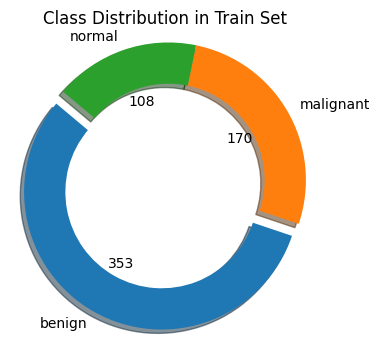

In [ ]:
for set_name in ['Train']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())
    explode = [0.1 if i == 0 else 0 for i in range(len(class_labels))]  # Explode the first segment

    plt.figure(figsize=(4, 4))  # Smaller figure size
    plt.pie(
        class_counts,
        labels=class_labels,
        startangle=140,
        autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100),
        explode=explode,
        shadow=True,
        wedgeprops={'width': 0.3}  # Doughnut plot style
    )
    plt.title(f'Class Distribution in {set_name} Set', fontsize=12)  # Smaller title font size
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


# **Create pie charts for each class of Validation set**

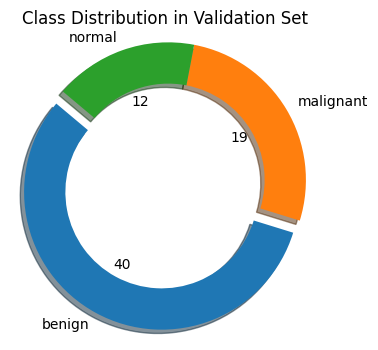

In [ ]:
for set_name in ['Validation']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())
    explode = [0.1 if i == 0 else 0 for i in range(len(class_labels))]  # Explode the first segment

    plt.figure(figsize=(4, 4))  # Smaller figure size
    plt.pie(
        class_counts,
        labels=class_labels,
        startangle=140,
        autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100),
        explode=explode,
        shadow=True,
        wedgeprops={'width': 0.3}  # Doughnut plot style
    )
    plt.title(f'Class Distribution in {set_name} Set', fontsize=12)  # Smaller title font size
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

# **Create pie charts for each class of Test set**

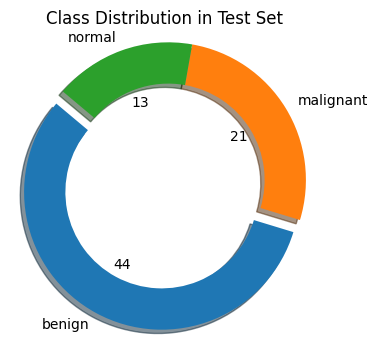

In [ ]:
for set_name in ['Test']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())
    explode = [0.1 if i == 0 else 0 for i in range(len(class_labels))]  # Explode the first segment

    plt.figure(figsize=(4,4))
    plt.pie(
        class_counts,
        labels=class_labels,
        startangle=140,
        autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100),
        explode=explode,
        shadow=True,
        wedgeprops={'width': 0.3}  # Create a doughnut plot
    )
    plt.title(f'Class Distribution in {set_name} Set')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

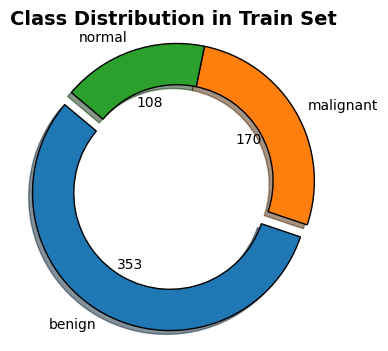

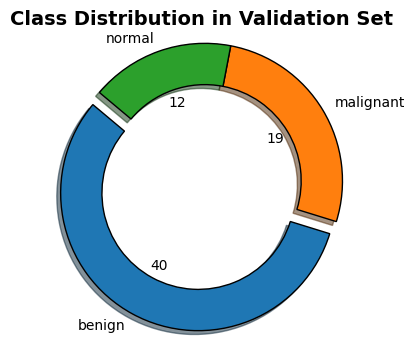

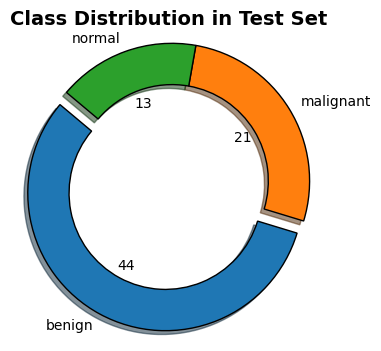

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Class names mapping
class_names_mapping = {0: "benign", 1: "malignant", 2: "normal"}

# Example class distribution based on the shape of your labels
# You can calculate the distribution using np.sum on one-hot encoded labels
class_counts_train = np.sum(train_labels, axis=0)
class_counts_val = np.sum(val_labels, axis=0)
class_counts_test = np.sum(test_labels, axis=0)

# Class distribution mapping
class_counts_mapping = {
    "benign": {'Train': class_counts_train[0], 'Validation': class_counts_val[0], 'Test': class_counts_test[0]},
    "malignant": {'Train': class_counts_train[1], 'Validation': class_counts_val[1], 'Test': class_counts_test[1]},
    "normal": {'Train': class_counts_train[2], 'Validation': class_counts_val[2], 'Test': class_counts_test[2]}
}

# Plotting the donut chart for each set
for set_name in ['Train', 'Validation', 'Test']:
    # Get the counts for the set
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    # Explode the first segment for emphasis
    explode = [0.1 if i == 0 else 0 for i in range(len(class_labels))]

    # Plotting the donut chart
    plt.figure(figsize=(4, 4))  # Set figure size
    plt.pie(
        class_counts,
        labels=class_labels,
        startangle=140,
        autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100),
        explode=explode,
        shadow=True,
        wedgeprops={'width': 0.3, 'edgecolor': 'black'}  # Doughnut style with black edges
    )
    plt.title(f'Class Distribution in {set_name} Set', fontsize=14, fontweight='bold')  # Title customization
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
